<a href="https://colab.research.google.com/github/DiegoSnach/The-final-project-GLUE/blob/master/3_FINAL_MPRC_SiameseLSTM_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from time import time
import datetime
import pandas as pd
import numpy as np
import re
import os
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


GPU is available


In [ ]:
# if `batch_size=-1`, will return the full dataset as `tf.tensor`s. ABSOLUTELY FUNDAMENTAL!

train_data, validation_data = tfds.load(name='glue/mrpc', split=['train', 'validation'], batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete0D4WSA/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete0D4WSA/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete0D4WSA/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# check dataset

train_data.keys()

dict_keys(['idx', 'label', 'sentence1', 'sentence2'])

In [ ]:
# Convert to dataFrame

df_train = pd.DataFrame(data=train_data)
df_validation = pd.DataFrame(data=validation_data)

In [ ]:
df_train.head()

,idx,label,sentence1,sentence2
0,1680,0,b'The identical rovers will act as robotic geo...,"b'The rovers act as robotic geologists , movin..."
1,1456,0,"b""Less than 20 percent of Boise 's sales would...","b""Less than 20 percent of Boise 's sales would..."
2,3017,1,b'Spider-Man snatched $ 114.7 million in its d...,"b'Spider-Man , rated PG-13 , snatched $ 114.7 ..."
3,2896,1,"b""The 2002 second quarter results don 't inclu...",b'The year-ago numbers do not include figures ...
4,499,0,b'Solomon 5.5 is available initially in the Un...,b'Solomon 5.5 is now available in the U.S. and...


In [ ]:
print(df_train['sentence1'][0])
print(df_train['sentence2'][0])
print(df_train['label'][0])


b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
b'The rovers act as robotic geologists , moving on six wheels .'
0


In [ ]:
# Creates function to clean data

def process_data (data):
  punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
  def clean_the_text (text, punt):
    for p in punct:
      text = text.replace(p, ' ')
      text = text.replace("b'", ' ', 1)
      text = text.replace('b"', ' ', 1)
    return text
  
  data =  data.astype(str).apply(lambda x: clean_the_text(x, punct))
  return data  

In [ ]:
# Change the datatypes as they come as tensor object

sentence1 = process_data(df_train.sentence1.apply(str))
sentence2 = process_data(df_train.sentence2.apply(str))
label = df_train.label
print(len(sentence1))
print(len(sentence2))
print(len(label))

3668
3668
3668


In [ ]:
# Check lenght of sentence

count = sentence1.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count.mean()))
print('Median: %f' % (count.median()))
print('Max: %f' % (count.max()))

Mean: 20.664667
Median: 21.000000
Max: 46.000000


In [ ]:
# Count it for sentence 2

count2 = sentence2.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count2.mean()))
print('Median: %f' % (count2.median()))
print('Max: %f' % (count2.max()))

Mean: 20.661668
Median: 20.000000
Max: 43.000000


In [ ]:
# Bring Keras tokenizer, builds vocabulary and pads sequences

Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

tokenizer = Tokenizer(num_words=20000)
max_len = 32 # Limit sentences to 40 words

# Creates vocabulary and gives number of tokens in corpus

tokenizer.fit_on_texts(list(sentence1) + list(sentence2))
vocab_size = len(tokenizer.word_index)+1 # Because starts counting at 0
print(vocab_size)

12430


In [ ]:
# Converts sentences to sequences of integers
# post pad them to max set to 40 

encoded_sent1 = tokenizer.texts_to_sequences(sentence1)
padded_sent1 = pad_sequences(encoded_sent1, maxlen=max_len, padding='post')

encoded_sent2 = tokenizer.texts_to_sequences(sentence2)
padded_sent2 = pad_sequences(encoded_sent2, maxlen=max_len, padding='post')

# Check
print(sentence1[5])
print(encoded_sent1[5])
print(padded_sent1[5])

 The family stopped for lunch at Freshwater Spit   where several children went to the water 's edge to play in the surf shortly after noon   
[1, 375, 2039, 11, 5809, 15, 9387, 9388, 155, 243, 376, 503, 3, 1, 531, 9, 5810, 3, 927, 6, 1, 5811, 2255, 43, 3777]
[   1  375 2039   11 5809   15 9387 9388  155  243  376  503    3    1
  531    9 5810    3  927    6    1 5811 2255   43 3777    0    0    0
    0    0    0    0]


In [ ]:
val_sentence1 = process_data(df_validation.sentence1.apply(str))
val_sentence2 = process_data(df_validation.sentence2.apply(str))
val_label = df_validation.label
print(len(val_sentence1))
print(len(val_sentence2))
print(len(val_label))

408
408
408


In [ ]:
# Converts sentences to sequences of integers for VAL_SET
# post pad them to max set to 40 

val_encoded_sent1 = tokenizer.texts_to_sequences(val_sentence1)
val_padded_sent1 = pad_sequences(val_encoded_sent1, maxlen=max_len, padding='post')

val_encoded_sent2 = tokenizer.texts_to_sequences(val_sentence2)
val_padded_sent2 = pad_sequences(val_encoded_sent2, maxlen=max_len, padding='post')

# Check
print(val_sentence1[5])
print(val_encoded_sent1[5])
print(val_padded_sent1[5])

   There were more people surrounding the clubhouse than the Unabomber  's house up in the hills     Baker said  '
[93, 23, 55, 64, 3625, 1, 61, 1, 9, 179, 47, 6, 1, 4837, 4320, 8, 2]
[  93   23   55   64 3625    1   61    1    9  179   47    6    1 4837
 4320    8    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [ ]:
# download pretrained GloVe embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip

In [ ]:
# Mount them from drive for quicker performance

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# lists files

!ls "/content/gdrive/My Drive/Glove/glove.6B.300d.txt"

'/content/gdrive/My Drive/Glove/glove.6B.300d.txt'


In [ ]:
# Creates dictionary of word embeddings

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join('/content/gdrive/My Drive/Glove/glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Matches words/tokens from vocabulary to their embeddings

embedding_dimensions = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimensions))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector   

In [ ]:
# Builds a dict for the two inputs of the Siamese LSTM

X_train = {'left': padded_sent1, 'right': padded_sent2}
Y_train = label

In [ ]:
# Make sure everything is ok
# CHECK WHETHER THIS IS NEEDED OR IT CAN BE DIFFERENT LENGHT

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [ ]:
# Builds a dict for the two inputs of the Siamese LSTM at validation as well

X_val = {'left': val_padded_sent1, 'right': val_padded_sent2}
Y_val = val_label

In [ ]:
Y_train

0       0
1       0
2       1
3       1
4       0
       ..
3663    0
3664    1
3665    1
3666    0
3667    1
Name: label, Length: 3668, dtype: int64

In [ ]:
# Make sure everything is ok
# CHECK WHETHER THIS IS NEEDED OR IT CAN BE DIFFERENT LENGHT

assert X_val['left'].shape == X_val['right'].shape
assert len(X_val['left']) == len(Y_val)

In [ ]:
# Calculates Manhattan Distance as in Jonas Mueller 
# https://gist.github.com/GKarmakar/3aa0c643ddb0688a9bfc44b43b84edd8

def manhattan_distance(left,right):
  return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [ ]:
# Starts building model Siamese LSTM

from tensorflow.python.keras.layers import Input, Embedding, LSTM, GRU, Conv1D, Conv2D, GlobalMaxPool1D, Dense, Dropout
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Layer, AdditiveAttention

In [ ]:
# Defines hidden dimensions of lstm and embedding
# From Jonas Mueller: The LSTM learns a mapping from the space of variable length 
# sequences of 300 dimensional vectors into 50 

n_hidden = 50

embed = Embedding(vocab_size, embedding_dimensions, weights=[embedding_matrix],input_length=max_len, trainable=False)

In [ ]:
# Defines LSTM_model and shows it

lstm_layer = Sequential()
lstm_layer.add(embed)
lstm_layer.add(LSTM(n_hidden, dropout=0.2, activation='tanh', recurrent_dropout=0.2))
lstm_layer.add(Dense(1, activation='sigmoid'))
lstm_layer.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 300)           3729000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 3,799,251
Trainable params: 70,251
Non-trainable params: 3,729,000
_________________________________________________________________


In [ ]:
# Defines left and right inputs to the lstm
# Input has automatic shape inference

left_input = Input(shape=(max_len,), dtype='int32')
right_input = Input(shape=(max_len,), dtype='int32')

# Output of the lstm

left = lstm_layer(left_input)
right = lstm_layer(right_input)

In [ ]:
# Calculates Manhattan Distance and instantiates the Model
# when training the model, the weights of the LSTM layer are updated based on both inputs

malstm_distance = manhattan_distance(left=left, right=right)
model = Model(inputs = [left_input, right_input], outputs = [malstm_distance])

In [ ]:
# Compiles with loss MSE and Adadelta as in Jonas Mueller. Prints summary

model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            3799251     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub_1 (TensorFlowOp [(None, 1)]          0           sequential_1[0][0]    

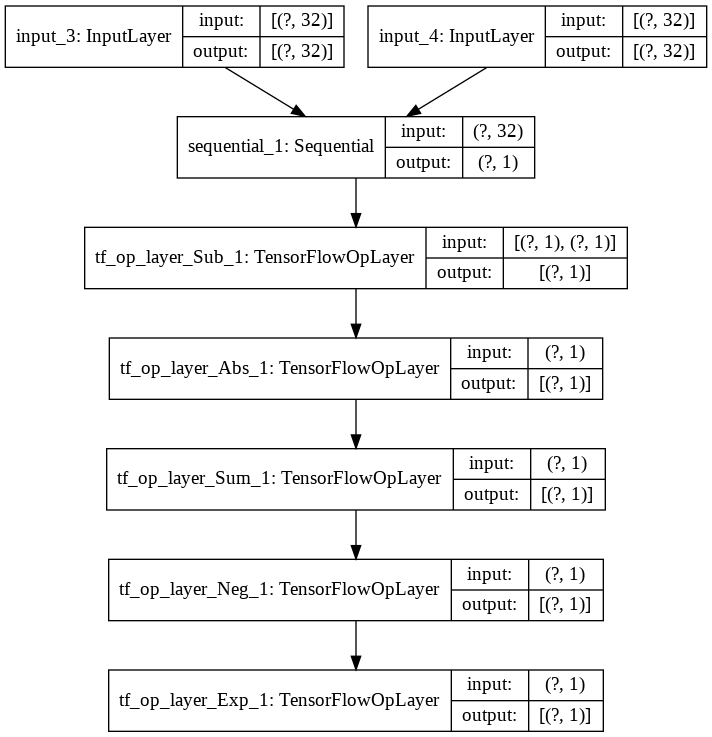

In [ ]:
# Plot model graph
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
# Early stopping to prevent under/over fitting

from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')

In [ ]:
# start training 
malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                           batch_size=32,
                           epochs=10, 
                           verbose=True, 
                           validation_split=0.2,
                           callbacks=[earlystop])

Epoch 1/10
92/92 [==============================] - 32s 345ms/step - loss: 0.2459 - accuracy: 0.6680 - val_loss: 0.2396 - val_accuracy: 0.6322
Epoch 2/10
92/92 [==============================] - 31s 341ms/step - loss: 0.2580 - accuracy: 0.6472 - val_loss: 0.2357 - val_accuracy: 0.6649
Epoch 3/10
92/92 [==============================] - 30s 328ms/step - loss: 0.2419 - accuracy: 0.6691 - val_loss: 0.2373 - val_accuracy: 0.6839
Epoch 4/10
92/92 [==============================] - 31s 336ms/step - loss: 0.2296 - accuracy: 0.6868 - val_loss: 0.2382 - val_accuracy: 0.6785
Epoch 5/10
92/92 [==============================] - 31s 340ms/step - loss: 0.2305 - accuracy: 0.6902 - val_loss: 0.2439 - val_accuracy: 0.6826
Epoch 6/10
92/92 [==============================] - 30s 329ms/step - loss: 0.2254 - accuracy: 0.6912 - val_loss: 0.2389 - val_accuracy: 0.6866
Epoch 7/10
92/92 [==============================] - 32s 344ms/step - loss: 0.2082 - accuracy: 0.7188 - val_loss: 0.2397 - val_accuracy: 0.6948

In [ ]:
# Uncomment and start again from Sequential to 
# Reset weights and retrain model

# K.clear_session()

In [ ]:
print("Evaluate on test data")

evaluation = model.evaluate([X_val['left'], X_val['right']], Y_val)

print("test loss, test acc:", evaluation)

Evaluate on test data
13/13 [==============================] - 0s 38ms/step - loss: 0.2361 - accuracy: 0.6912
test loss, test acc: [0.23613768815994263, 0.6911764740943909]


In [ ]:
# prediction = model.predict([X_val['left'],X_val['right']])
# print(prediction)

In [ ]:
max(malstm_trained.history['accuracy'])

0.731083869934082

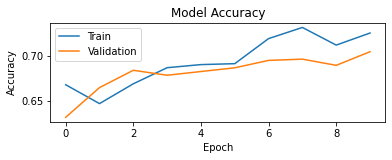

In [ ]:
# Plot Accuracy

plt.subplot(211)
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

In [ ]:
# Run 10 experiments and plot results

def make_model():
  tf.keras.backend.clear_session() # Starts session from scratch 
  print('New Experiment')
  lstm_layer = Sequential()
  lstm_layer.add(embed)
  lstm_layer.add(LSTM(n_hidden))  
  # lstm_layer.summary() 
  # Input has automatic shape inference
  left_input = Input(shape=(max_len,), dtype='int32')
  right_input = Input(shape=(max_len,), dtype='int32')
  # Output of the lstm
  left = lstm_layer(left_input)
  right = lstm_layer(right_input)
  # Calculates Manhattan Distance and instantiates the Model
  malstm_distance = manhattan_distance(left=left, right=right)
  model = Model(inputs = [left_input, right_input], outputs = [malstm_distance])
  model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                metrics=['accuracy'])
  malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train, 
                             batch_size=16, 
                             epochs=10, 
                             verbose=True, 
                             validation_split=0.2, 
                             callbacks=[earlystop])
  results2 = model.evaluate([X_val['left'], X_val['right']], Y_val)
  return results2

In [ ]:
colection = [make_model() for _ in range (10)]

Epoch 1/10
92/92 [==============================] - 31s 340ms/step - loss: 0.2484 - accuracy: 0.6748 - val_loss: 0.2435 - val_accuracy: 0.6894
Epoch 2/10
92/92 [==============================] - 31s 338ms/step - loss: 0.2375 - accuracy: 0.6830 - val_loss: 0.2316 - val_accuracy: 0.6839
Epoch 3/10
92/92 [==============================] - 30s 331ms/step - loss: 0.2372 - accuracy: 0.6779 - val_loss: 0.2362 - val_accuracy: 0.6839
Epoch 4/10
92/92 [==============================] - 31s 341ms/step - loss: 0.2247 - accuracy: 0.6922 - val_loss: 0.2390 - val_accuracy: 0.6935
Epoch 5/10
92/92 [==============================] - 32s 343ms/step - loss: 0.2138 - accuracy: 0.7007 - val_loss: 0.2328 - val_accuracy: 0.7016
Epoch 6/10
92/92 [==============================] - 31s 338ms/step - loss: 0.2044 - accuracy: 0.7113 - val_loss: 0.2422 - val_accuracy: 0.6826
Epoch 7/10
92/92 [==============================] - 32s 347ms/step - loss: 0.2027 - accuracy: 0.7212 - val_loss: 0.2312 - val_accuracy: 0.6812

In [ ]:
colection

[[0.22748184204101562, 0.6960784196853638],
 [0.23606981337070465, 0.6421568393707275],
 [0.28750079870224, 0.6838235259056091],
 [0.22617173194885254, 0.6985294222831726],
 [0.2461692988872528, 0.6789215803146362],
 [0.2467241734266281, 0.6813725233078003],
 [0.23974765837192535, 0.6127451062202454],
 [0.23867987096309662, 0.6838235259056091],
 [0.23916195333003998, 0.6936274766921997],
 [0.2417765110731125, 0.6421568393707275]]

In [ ]:

x = []
for i in range (len(colection)):
  x.append(colection[i][1])

In [ ]:
x

[0.6960784196853638,
 0.6421568393707275,
 0.6838235259056091,
 0.6985294222831726,
 0.6789215803146362,
 0.6813725233078003,
 0.6127451062202454,
 0.6838235259056091,
 0.6936274766921997,
 0.6421568393707275]

In [ ]:
import statistics
median_value = statistics.median(x)
median_value

0.6825980246067047

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

Text(0, 0.5, 'Accuracy')

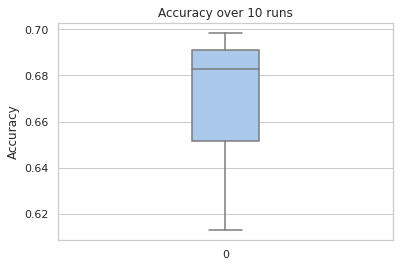

In [ ]:
ax = sns.boxplot(data=x, width=0.2)

ax.set_title("Pearson Correlation over 10 runs")
ax.set_ylabel('Pearson Correlation ')